# Exploratory Data Analysis for Patient Readmission
Colin Reinacher / converted for CojoLightning

This notebook performs a reproducible EDA workflow for patient readmission prediction, handling missing data defensively, creating a binary target for 30-day readmission, producing diagnostic plots and CSV summaries, and running a simple baseline logistic model to estimate signal.

Notes:
- Update the DATA_PATH variable in the configuration cell to point to your CSV file (default is `diabetic_data.csv`).
- The notebook is conservative about memory and sampling for large datasets.
- Outputs (plots and CSVs) are saved to `./eda_plots/` by default.


In [2]:
# Install dependencies if needed (uncomment and run once in the notebook kernel)
# !pip install pandas numpy matplotlib seaborn scikit-learn scipy

import os
import textwrap
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

sns.set(style="whitegrid")


In [3]:
# Configuration - update DATA_PATH to your CSV file path if needed
DATA_PATH = "C:/Users/reinacherc/Downloads/diabetes+130-us+hospitals+for+years+1999-2008 (1)/diabetic_data.csv"   # change to your path
MAPPING_PATH = None  # optional mapping file
PLOT_DIR = "../eda_plots"
RANDOM_STATE = 42
os.makedirs(PLOT_DIR, exist_ok=True)


In [4]:
def load_data(path: str) -> pd.DataFrame:
    """Load CSV into DataFrame with safe defaults and normalized column names."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    return df

def brief_info(df: pd.DataFrame):
    print("Data shape:", df.shape)
    print("\nColumns and dtypes:")
    print(df.dtypes.value_counts(dropna=False).to_string())
    print("\nFirst 5 rows:")
    print(df.head().T)
    print("\nMemory usage (MB): {:.2f}".format(df.memory_usage(deep=True).sum() / 1024**2))

def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isnull().sum()
    pct = (miss / len(df)) * 100
    uniques = df.nunique(dropna=False)
    summary = pd.DataFrame({
        "missing_count": miss,
        "missing_pct": pct,
        "unique_count": uniques,
        "dtype": df.dtypes.astype(str)
    }).sort_values("missing_pct", ascending=False)
    return summary

def plot_missingness_matrix(df: pd.DataFrame, fname: str = None):
    sample_frac = 0.1 if len(df) > 5000 else 1.0
    sampled = df.sample(frac=sample_frac, random_state=RANDOM_STATE)
    plt.figure(figsize=(14, max(4, len(sampled.columns) / 3)))
    sns.heatmap(sampled.isnull().T, cbar=False, cmap=["#2ecc71", "#e74c3c"])
    plt.xlabel("samples (possibly sampled)")
    plt.ylabel("columns")
    plt.title("Missingness matrix (red = missing)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def plot_missingness_by_target(df: pd.DataFrame, target_col: str, fname: str = None):
    col_miss = df.isnull().mean().sort_values(ascending=False)
    top_cols = col_miss.index[:20].tolist()
    if target_col not in df.columns:
        return
    miss_by_target = df[top_cols + [target_col]].groupby(target_col).apply(lambda g: g.isnull().mean()).T
    plt.figure(figsize=(12, max(4, len(top_cols) * 0.4)))
    miss_by_target.plot.barh(stacked=False)
    plt.xlabel("Fraction missing")
    plt.title("Missingness fraction by target class")
    plt.legend(title=target_col)
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def summarize_numeric(df: pd.DataFrame, numeric_cols: List[str], fname: str = None):
    if not numeric_cols:
        return
    desc = df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
    print("\nNumeric features summary (selected percentiles):")
    # Select keys that exist to avoid KeyError
    keys = [k for k in ["count", "mean", "std", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99%", "max"] if k in desc.columns]
    print(desc[keys])
    n = len(numeric_cols)
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for i, c in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[c].dropna(), kde=False, bins=30)
        plt.title(c)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def summarize_categorical(df: pd.DataFrame, cat_cols: List[str], top_k: int = 10, fname: str = None):
    if not cat_cols:
        return
    print("\nTop categories per categorical feature (showing up to top_k):")
    for c in cat_cols:
        counts = df[c].value_counts(dropna=False).head(top_k)
        print(f"\n{c} ({df[c].dtype}) - unique: {df[c].nunique(dropna=True)}")
        print(counts.to_string())
    card = df[cat_cols].nunique().sort_values(ascending=False)
    plot_cols = card.head(6).index.tolist()
    plt.figure(figsize=(14, 3 * len(plot_cols)))
    for i, c in enumerate(plot_cols, 1):
        plt.subplot(len(plot_cols), 1, i)
        sns.countplot(y=c, data=df, order=df[c].value_counts().index[:20])
        plt.title(c)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def target_engineering(df: pd.DataFrame, target_col: str = "readmitted") -> pd.DataFrame:
    if target_col not in df.columns:
        print(f"Warning: target column {target_col} not in DataFrame. Skipping target engineering.")
        return df
    df = df.copy()
    vals = df[target_col].astype(str).str.strip()
    df["readmit_30"] = np.where(vals == "<30", 1, 0)
    df["readmit_original"] = df[target_col]
    print("\nTarget value counts (original):")
    print(df[target_col].value_counts(dropna=False))
    print("\nBinary target value counts (readmit_30):")
    print(df["readmit_30"].value_counts(dropna=False))
    return df

def quick_target_plots(df: pd.DataFrame, target: str = "readmit_30", fname: str = None):
    if target not in df.columns:
        return
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target, data=df)
    plt.title("Target distribution (binary)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def correlation_with_target(df: pd.DataFrame, numeric_cols: List[str], target: str) -> pd.Series:
    corrs = {}
    if target not in df.columns:
        return pd.Series(dtype=float)
    for c in numeric_cols:
        try:
            if df[c].dropna().shape[0] < 10:
                corrs[c] = np.nan
                continue
            corrs[c] = df[[c, target]].dropna().corr().iloc[0, 1]
        except Exception:
            corrs[c] = np.nan
    return pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)

def mutual_information_rank(df: pd.DataFrame, features: List[str], target: str, discrete_threshold: int = 20) -> pd.Series:
    if target not in df.columns:
        return pd.Series(dtype=float)
    X = df[features].copy()
    y = df[target]
    for col in X.columns:
        if X[col].dtype == "object" or X[col].nunique(dropna=True) <= discrete_threshold:
            X[col] = X[col].astype("category").cat.codes.replace({-1: np.nan})
    X = X.fillna(-999)
    y = y.fillna(0)
    try:
        mi = mutual_info_classif(X, y, discrete_features="auto", random_state=RANDOM_STATE)
        return pd.Series(mi, index=features).sort_values(ascending=False)
    except Exception as e:
        print("Mutual information calculation failed:", e)
        return pd.Series(dtype=float)

def baseline_logistic_cv(df: pd.DataFrame, target: str, max_features: int = 50) -> Tuple[float, pd.DataFrame]:
    if target not in df.columns:
        print("Target not present; skipping baseline model.")
        return 0.0, pd.DataFrame()
    exclude = {target, "readmit_original"}
    candidates = [c for c in df.columns if c not in exclude]
    candidates = [c for c in candidates if df[c].nunique(dropna=True) > 1 and df[c].nunique(dropna=True) < len(df) * 0.9]
    mi = mutual_information_rank(df, candidates, target)
    top_features = mi.dropna().head(max_features).index.tolist()
    print(f"\nTop {len(top_features)} features by mutual information:")
    print(mi.head(20))
    X = df[top_features]
    y = df[target]
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ], remainder="drop")
    clf = Pipeline(steps=[
        ("pre", preprocessor),
        ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    try:
        scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        print("\nBaseline logistic regression AUC scores (5-fold):", scores)
        print("Mean AUC:", np.nanmean(scores))
    except Exception as e:
        print("Baseline model training failed:", e)
        scores = np.array([np.nan])
    return np.nanmean(scores), mi


In [5]:
def run_eda(data_path: str = DATA_PATH, mapping_path: str = MAPPING_PATH):
    print("Loading data from:", data_path)
    df = load_data(data_path)
    if mapping_path:
        if os.path.exists(mapping_path):
            try:
                with open(mapping_path, "r", encoding="utf-8") as f:
                    mapping_text = f.read()
                print("Loaded mapping file (first 500 chars):")
                print(mapping_text[:500])
            except Exception as e:
                print("Failed to read mapping file:", e)
    brief_info(df)
    miss_summary = missing_summary(df)
    print("\nMissingness summary (top 50 rows):")
    print(miss_summary.head(50).to_string())
    miss_summary.to_csv(os.path.join(PLOT_DIR, "missing_summary.csv"))
    plot_missingness_matrix(df, fname=os.path.join(PLOT_DIR, "missingness_matrix.png"))
    df = target_engineering(df, target_col="readmitted")
    quick_target_plots(df, target="readmit_30", fname=os.path.join(PLOT_DIR, "target_distribution.png"))
    if "readmit_30" in df.columns:
        plot_missingness_by_target(df, "readmit_30", fname=os.path.join(PLOT_DIR, "missing_by_target.png"))
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ("readmit_30",)]
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    categorical_cols = [c for c in categorical_cols if c not in ("readmit_original",)]
    summarize_numeric(df, numeric_cols, fname=os.path.join(PLOT_DIR, "numeric_histograms.png"))
    summarize_categorical(df, categorical_cols, fname=os.path.join(PLOT_DIR, "categorical_counts.png"))
    if "readmit_30" in df.columns and numeric_cols:
        corrs = correlation_with_target(df, numeric_cols, "readmit_30")
        print("\nNumeric correlations with target (top 20 by absolute):")
        print(corrs.dropna().head(20).to_string())
        corrs.to_csv(os.path.join(PLOT_DIR, "numeric_target_correlations.csv"))
    candidates = numeric_cols + categorical_cols
    if "readmit_30" in df.columns and candidates:
        mi = mutual_information_rank(df, candidates, "readmit_30")
        print("\nMutual information ranking (top 30):")
        print(mi.head(30).to_string())
        mi.to_csv(os.path.join(PLOT_DIR, "mutual_information_ranking.csv"))
    auc_mean, mi = baseline_logistic_cv(df, "readmit_30", max_features=50)
    print("\nBaseline CV mean AUC:", auc_mean)
    print("\nRecommendations & next steps:")
    print(textwrap.dedent("""
        - Several columns may have high missingness. Consider:
            * Dropping columns with >80-90% missingness unless clinically important.
            * Imputing numeric values with median or model-based imputation.
            * Imputing categorical values with a separate '__MISSING__' category or using MICE.
        - Encode categorical variables with attention to cardinality (group rare levels).
        - Investigate time/order features and patient identifiers to avoid leakage.
        - Stratify train/test splits by important strata (hospital, patient ID) to avoid leakage.
        - Consider richer models and calibration after thorough feature engineering and handling of imbalanced classes.
    """))
    print(f"\nSaved plots & CSVs to: {os.path.abspath(PLOT_DIR)}")
    return df


Loading data from: C:/Users/reinacherc/Downloads/diabetes+130-us+hospitals+for+years+1999-2008 (1)/diabetic_data.csv
Data shape: (101766, 50)

Columns and dtypes:
object    37
int64     13

First 5 rows:
                                                 0          1  \
encounter_id                               2278392     149190   
patient_nbr                                8222157   55629189   
race                                     Caucasian  Caucasian   
gender                                      Female     Female   
age                                         [0-10)    [10-20)   
weight                                           ?          ?   
admission_type_id                                6          1   
discharge_disposition_id                        25          1   
admission_source_id                              1          7   
time_in_hospital                                 1          3   
payer_code                                       ?          ?   
medical_specialt

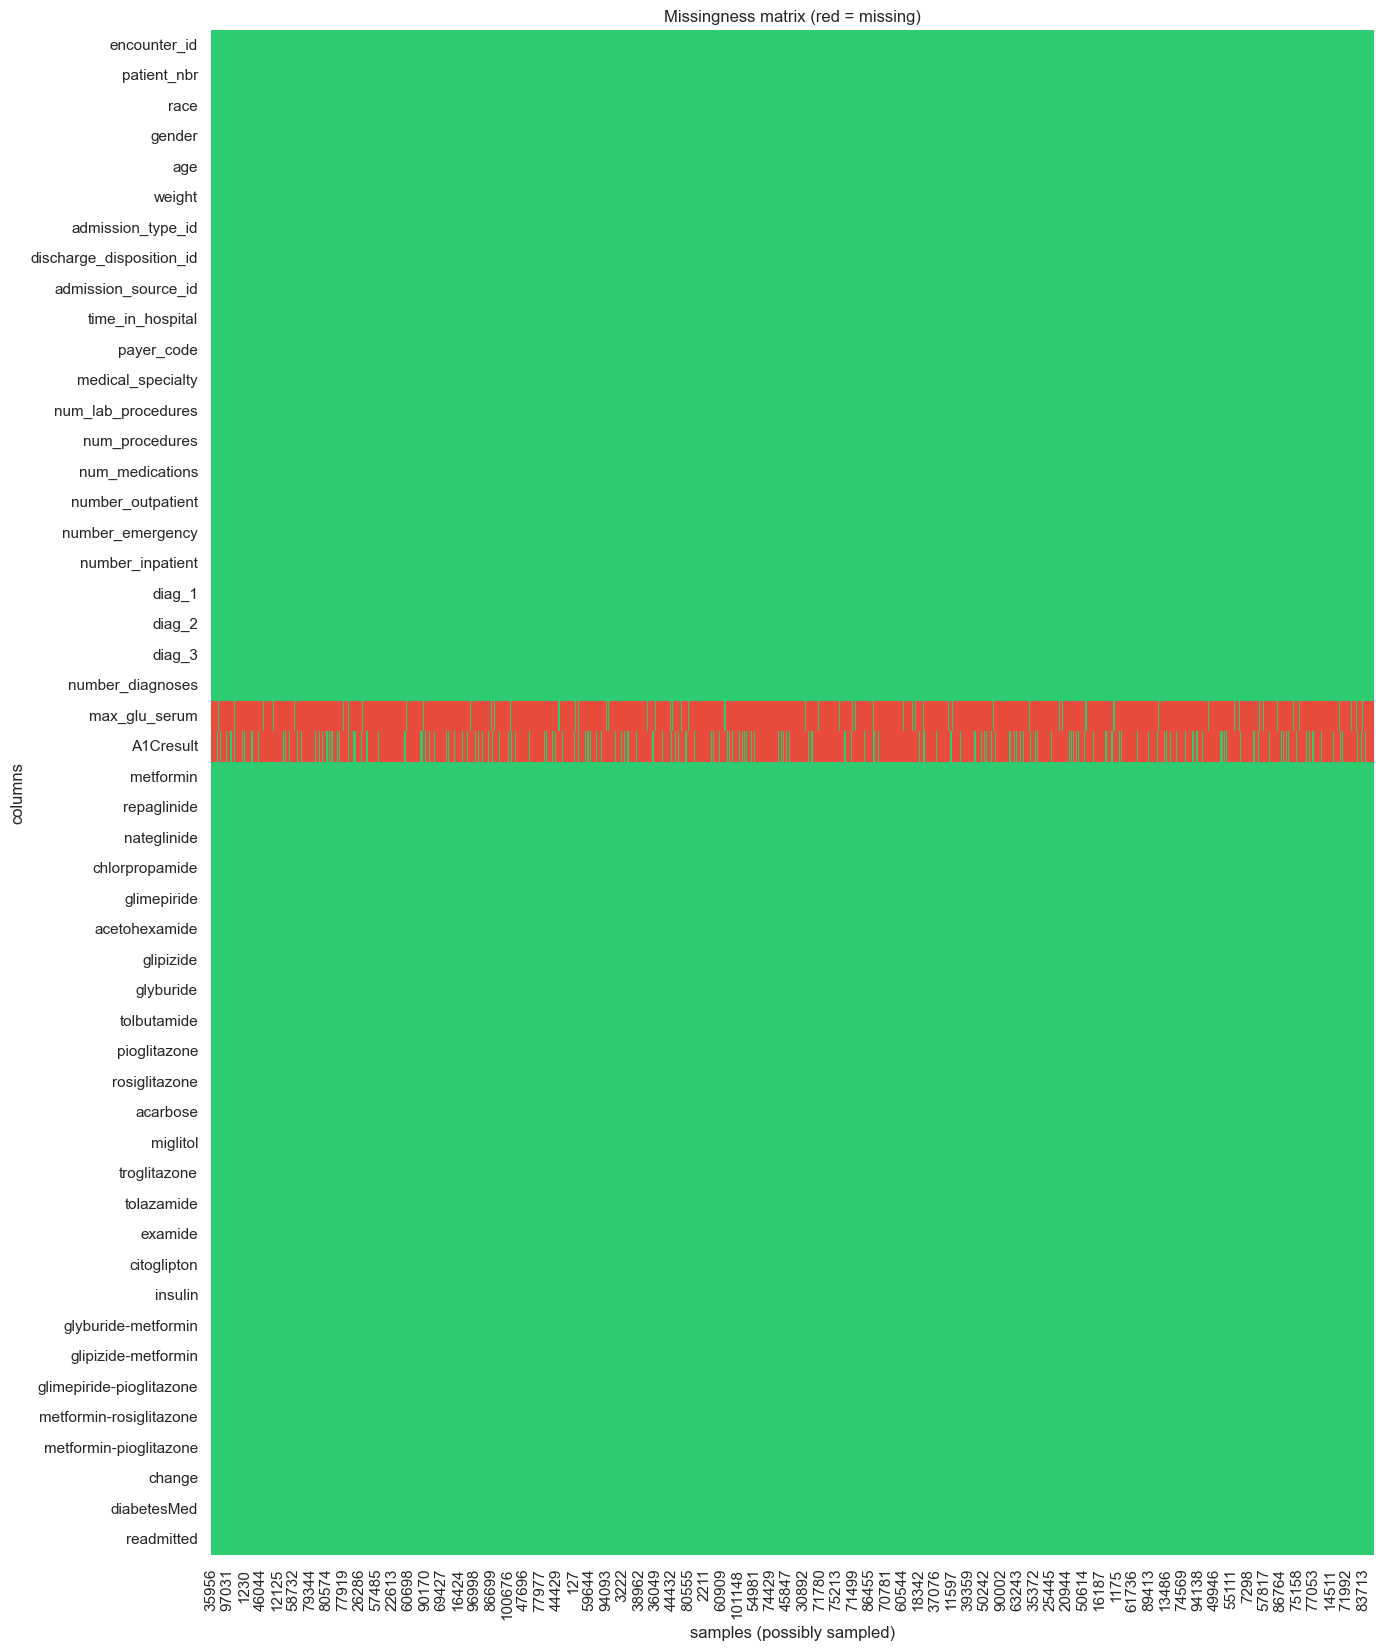


Target value counts (original):
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Binary target value counts (readmit_30):
readmit_30
0    90409
1    11357
Name: count, dtype: int64


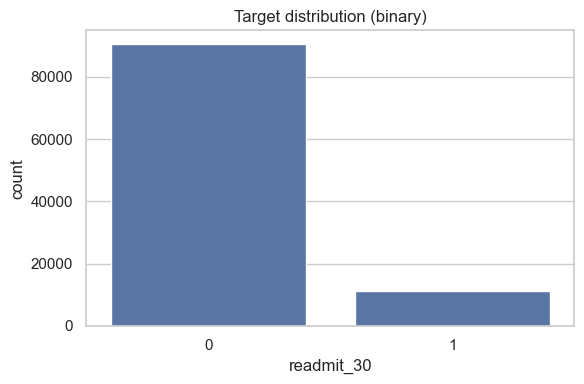

C:\Users\reinacherc\AppData\Local\Temp\ipykernel_25588\3963924860.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_by_target = df[top_cols + [target_col]].groupby(target_col).apply(lambda g: g.isnull().mean()).T


<Figure size 1200x800 with 0 Axes>

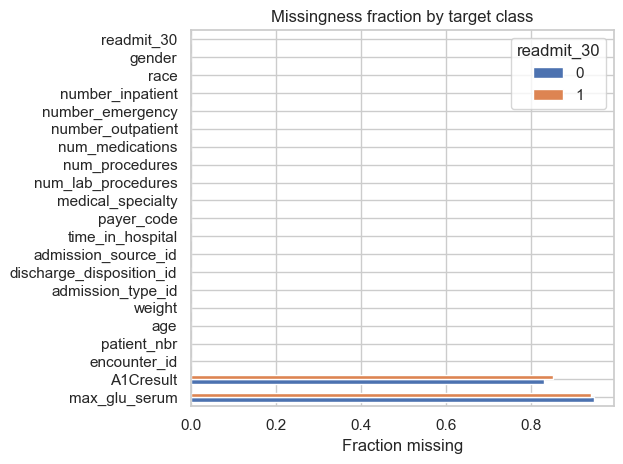


Numeric features summary (selected percentiles):
                             count          mean           std      min  \
encounter_id              101766.0  1.652016e+08  1.026403e+08  12522.0   
patient_nbr               101766.0  5.433040e+07  3.869636e+07    135.0   
admission_type_id         101766.0  2.024006e+00  1.445403e+00      1.0   
discharge_disposition_id  101766.0  3.715642e+00  5.280166e+00      1.0   
admission_source_id       101766.0  5.754437e+00  4.064081e+00      1.0   
time_in_hospital          101766.0  4.395987e+00  2.985108e+00      1.0   
num_lab_procedures        101766.0  4.309564e+01  1.967436e+01      1.0   
num_procedures            101766.0  1.339730e+00  1.705807e+00      0.0   
num_medications           101766.0  1.602184e+01  8.127566e+00      1.0   
number_outpatient         101766.0  3.693572e-01  1.267265e+00      0.0   
number_emergency          101766.0  1.978362e-01  9.304723e-01      0.0   
number_inpatient          101766.0  6.355659e-01  

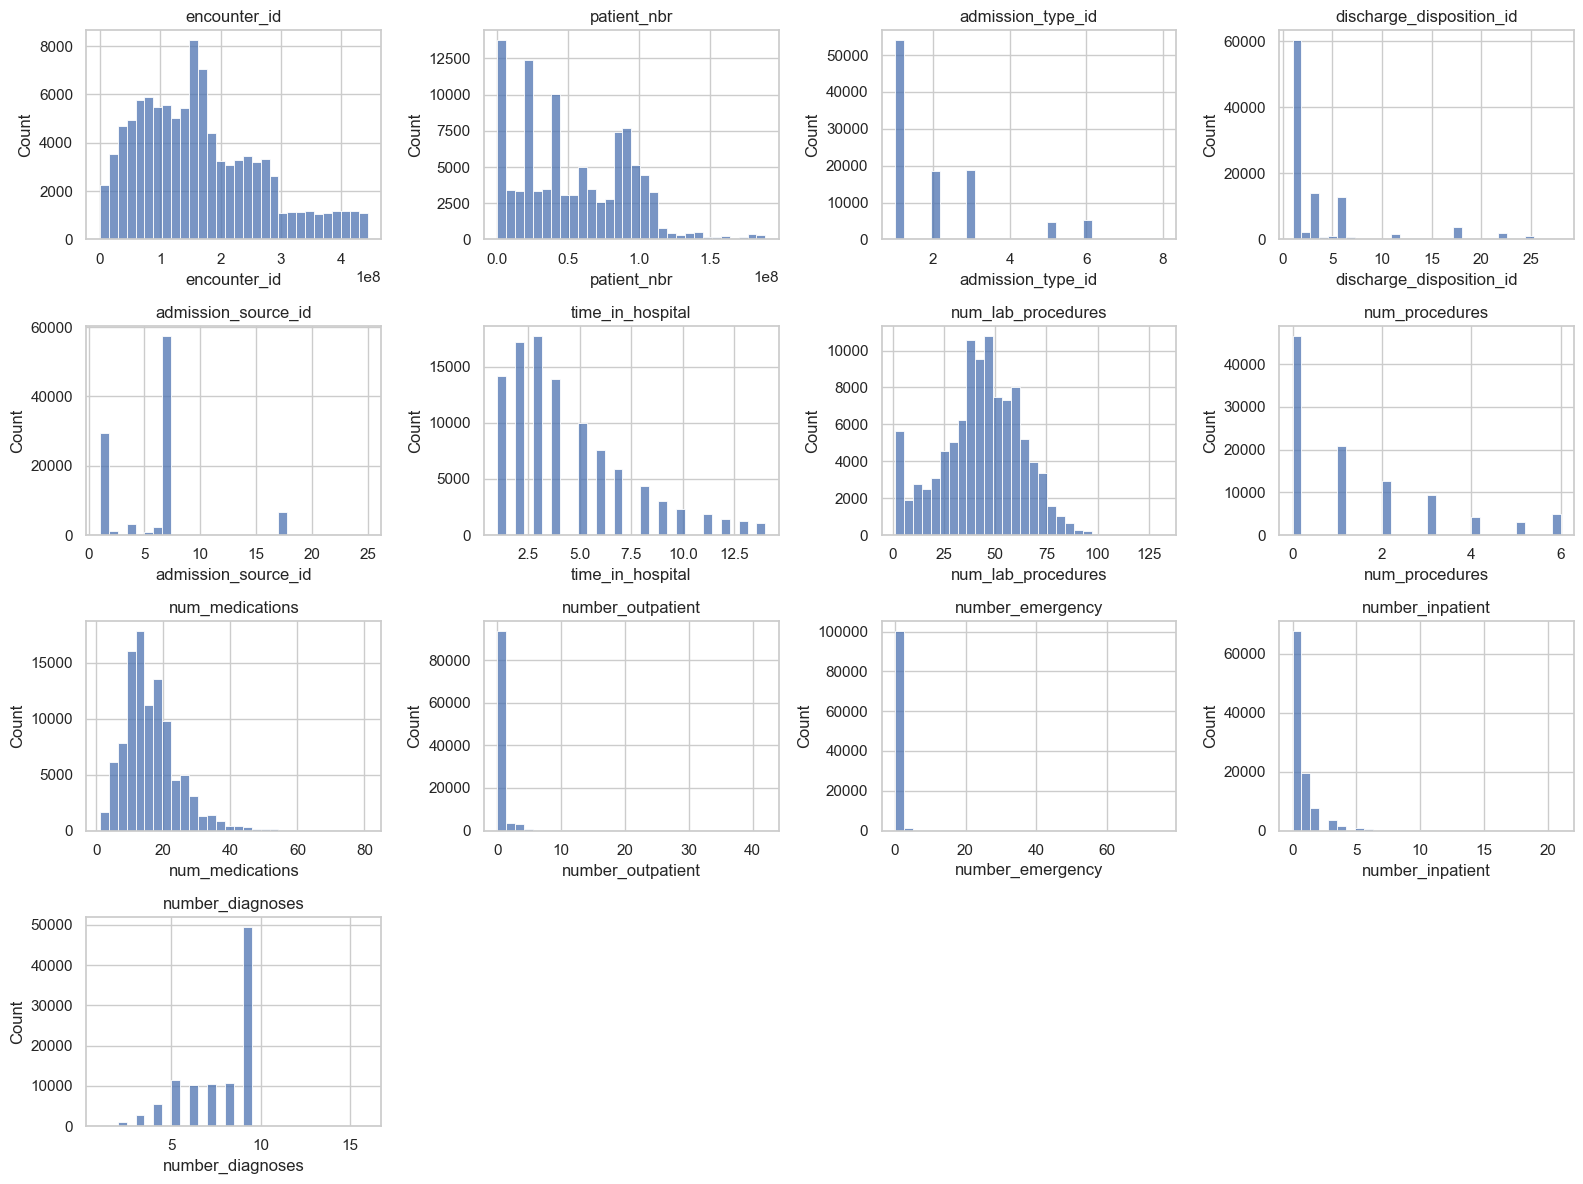


Top categories per categorical feature (showing up to top_k):

race (object) - unique: 6
race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641

gender (object) - unique: 3
gender
Female             54708
Male               47055
Unknown/Invalid        3

age (object) - unique: 10
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161

weight (object) - unique: 10
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3

payer_code (object) - unique: 18
payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033

medical_specialty (object) - unique: 73


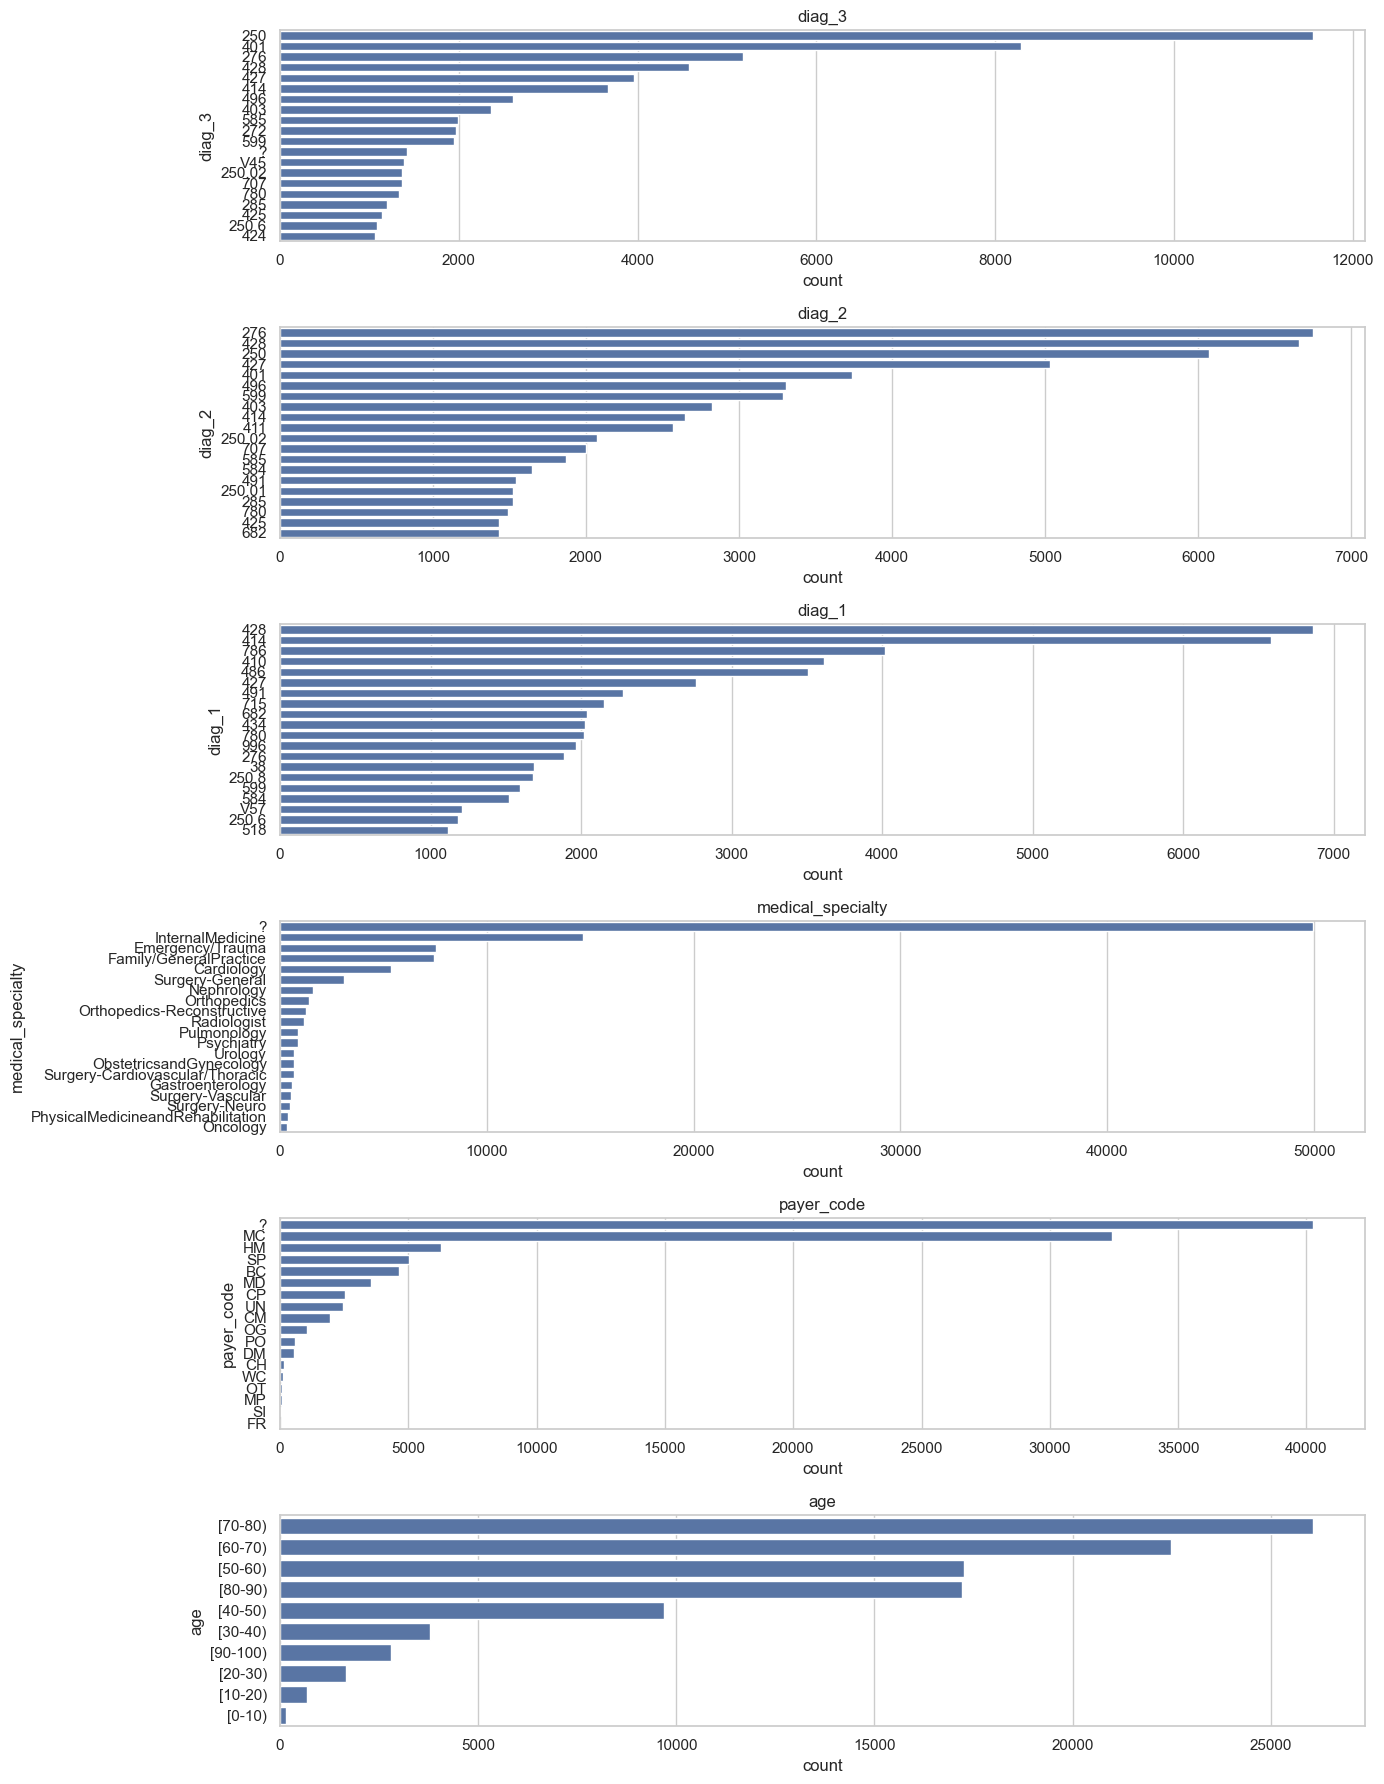


Numeric correlations with target (top 20 by absolute):
number_inpatient            0.165147
number_emergency            0.060747
discharge_disposition_id    0.050560
number_diagnoses            0.049524
time_in_hospital            0.044199
num_medications             0.038432
num_lab_procedures          0.020364
number_outpatient           0.018893
num_procedures             -0.012227
admission_type_id          -0.011651
encounter_id               -0.008519
patient_nbr                 0.007893
admission_source_id         0.005820

Mutual information ranking (top 30):
readmitted                  0.360999
max_glu_serum               0.024197
acarbose                    0.023454
glimepiride                 0.021614
A1Cresult                   0.018788
diabetesMed                 0.017838
nateglinide                 0.017210
miglitol                    0.017207
glyburide-metformin         0.016969
change                      0.014204
glyburide                   0.013408
repaglinide       

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [7]:
# Run EDA on the configured DATA_PATH. Change DATA_PATH above before running if needed.
try:
    df = run_eda(DATA_PATH)
except FileNotFoundError as e:
    print(e)
    print("If your file is in a different location, edit the DATA_PATH variable in the configuration cell and re-run this cell.")


Done: this notebook contains the full EDA script converted into notebook cells. It prints summaries, saves CSVs and plots into `./eda_plots/`, and runs a quick baseline logistic regression to estimate signal (AUC).

Next steps you might take interactively:
- Update DATA_PATH to your dataset path and re-run the last cell.
- Inspect the saved CSVs in `eda_plots/` and the generated PNGs.
- If columns are mostly missing but clinically important, consider collecting/imputing those carefully.
- Use the mutual information ranking and correlations to guide feature engineering and model development.

If you'd like, I can:
- Add interactive widgets to pick columns to include/exclude, or
- Add functions for advanced imputation (e.g., IterativeImputer / MICE), or
- Scaffold a training notebook that trains, tunes, and evaluates multiple models with proper patient-level splitting.
